# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import cv2
import glob
import numpy as np
from PIL import Image

# TODO: Fill this in based on where you saved the training and testing data

training_file = '/root/CarND-Traffic-Sign-Classifier-Project/traffic-signs-data/train.p'
testing_file = '/root/CarND-Traffic-Sign-Classifier-Project/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(list(set(y_train)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

11


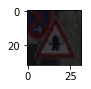

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

EPOCHS = 100
BATCH_SIZE = 128
rate = 0.001
# dropout = 0.75

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** creates x and y as inputs and output of the model, then convert y to one-hot vector. Define dropout to ease overfitting.

In [5]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=0.1, random_state=0
)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** didn't touch the testing data, but split the original training data into 90% training vs. 10% validation data.

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
def LeNet(x, drop):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x36.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 36), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(36))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x36. Output = 14x14x36.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x128.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 36, 128), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(128))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x128. Output = 5x5x128.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x128. Output = 3200.
    fc0 = flatten(conv2)

    # SOLUTION: Layer 3: Fully Connected. Input = 3200. Output = 800.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(3200, 800), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(800))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b

    # SOLUTION: Activation.
    fc1 = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 800. Output = 200.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(800, 200), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(200))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b

    # SOLUTION: Activation.
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, drop)

    # SOLUTION: Layer 5: Fully Connected. Input = 200. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(200, 43), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits


logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, dropout):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** Input => ConvNet => ReLU => MaxPool => ConvNet => ReLU => MaxPool => FC => ReLU => FC => ReLU => Dropout => SoftMax <> Labels

In [7]:
### Train your model here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    dropout = 0.75

    print("Training...")
    print()

    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})

        validation_accuracy = evaluate(X_validation, y_validation, dropout)
        print("EPOCH {} ...".format(i + 1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    try:
        saver
    except NameError:
        saver = tf.train.Saver()

    saver.save(sess, './lenet')
    print("Model saved")
    
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    dropout = 1

    test_accuracy = evaluate(X_test, y_test, dropout)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Training...

EPOCH 1 ...
Validation Accuracy = 0.143

EPOCH 2 ...
Validation Accuracy = 0.163

EPOCH 3 ...
Validation Accuracy = 0.195

EPOCH 4 ...
Validation Accuracy = 0.241

EPOCH 5 ...
Validation Accuracy = 0.254

EPOCH 6 ...
Validation Accuracy = 0.257

EPOCH 7 ...
Validation Accuracy = 0.286

EPOCH 8 ...
Validation Accuracy = 0.310

EPOCH 9 ...
Validation Accuracy = 0.331

EPOCH 10 ...
Validation Accuracy = 0.371

EPOCH 11 ...
Validation Accuracy = 0.385

EPOCH 12 ...
Validation Accuracy = 0.403

EPOCH 13 ...
Validation Accuracy = 0.422

EPOCH 14 ...
Validation Accuracy = 0.422

EPOCH 15 ...
Validation Accuracy = 0.449

EPOCH 16 ...
Validation Accuracy = 0.451

EPOCH 17 ...
Validation Accuracy = 0.471

EPOCH 18 ...
Validation Accuracy = 0.476

EPOCH 19 ...
Validation Accuracy = 0.541

EPOCH 20 ...
Validation Accuracy = 0.560

EPOCH 21 ...
Validation Accuracy = 0.607

EPOCH 22 ...
Validation Accuracy = 0.685

EPOCH 23 ...
Validation Accuracy = 0.695

EPOCH 24 ...
Validation Accura

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** AdamOptimizer, Batch Size 128, 100 epochs, learning rate: 0.001, dropout 0.75

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** Based on LeNet, trying to fine tune parameters including leanring rate, dropout, some network archetecture changes like adjust the position of some ConvNets and the amount of parameters and depth of these ConvNets. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

predict_img = []
image_list = []

for image_path in glob.glob("./traffic/*.jpg"):
    #collect names of these iamges
    print(image_path)
    image_list.append(image_path)
    #cv_image = cv2.imread(image_path)
    cv_image = Image.open(image_path)
    print(cv_image)
    res_image = np.array(cv_image)
    # collection of images to be processed
    predict_img.append(res_image)
    
print(image_list)

./traffic/70_32_32.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=32x32 at 0x7EFF940AFA58>
./traffic/stop_32_32.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=32x32 at 0x7EFF25AF20F0>
./traffic/ped_32_32.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=32x32 at 0x7EFF940AFA58>
./traffic/30_32_32.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=32x32 at 0x7EFF25AF2F28>
./traffic/yield_32_32.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=32x32 at 0x7EFF25AFF048>
./traffic/kindergarten_32_32.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=32x32 at 0x7EFF25AFF128>
['./traffic/70_32_32.jpg', './traffic/stop_32_32.jpg', './traffic/ped_32_32.jpg', './traffic/30_32_32.jpg', './traffic/yield_32_32.jpg', './traffic/kindergarten_32_32.jpg']


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** low resolution, skewed images, out of focus


./traffic/70_32_32.jpg
value: 1.0 <==> index: 1
value: 4.985242975361051e-25 <==> index: 0
value: 7.578590568318149e-27 <==> index: 8
value: 1.691187763289856e-33 <==> index: 26
value: 8.00045641576837e-37 <==> index: 32


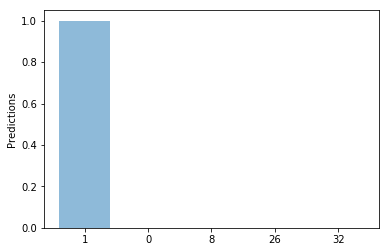


./traffic/stop_32_32.jpg
value: 1.0 <==> index: 14
value: 0.0 <==> index: 0
value: 0.0 <==> index: 1
value: 0.0 <==> index: 2
value: 0.0 <==> index: 3


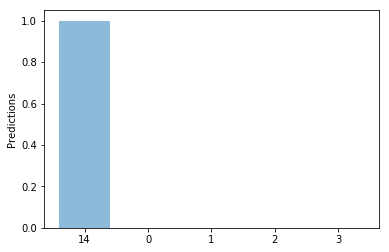


./traffic/ped_32_32.jpg
value: 1.0 <==> index: 27
value: 7.915009793413308e-13 <==> index: 24
value: 6.170306371964043e-14 <==> index: 18
value: 1.92608372322816e-19 <==> index: 26
value: 5.492880765998425e-23 <==> index: 11


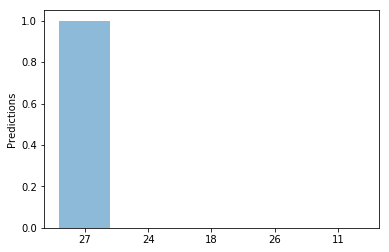


./traffic/30_32_32.jpg
value: 1.0 <==> index: 1
value: 0.0 <==> index: 0
value: 0.0 <==> index: 2
value: 0.0 <==> index: 3
value: 0.0 <==> index: 4


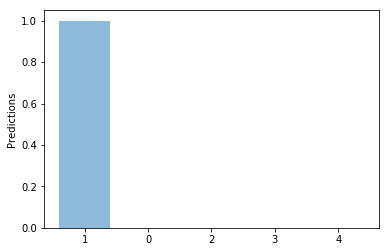


./traffic/yield_32_32.jpg
value: 1.0 <==> index: 13
value: 0.0 <==> index: 0
value: 0.0 <==> index: 1
value: 0.0 <==> index: 2
value: 0.0 <==> index: 3


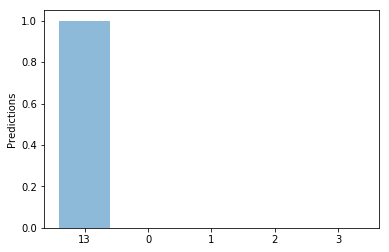


./traffic/kindergarten_32_32.jpg
value: 1.0 <==> index: 28
value: 0.0 <==> index: 0
value: 0.0 <==> index: 1
value: 0.0 <==> index: 2
value: 0.0 <==> index: 3


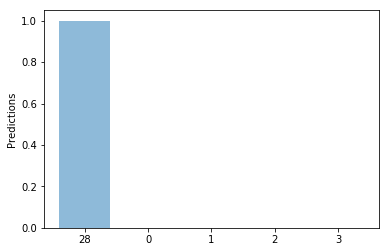

In [15]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('./lenet.meta')
    new_saver.restore(sess, './lenet')
    
    dropout = 1

    # prediction operations
    predict_op = tf.nn.softmax(logits)
    result = sess.run(
        predict_op, feed_dict={x: predict_img, keep_prob: dropout}
    )

    values, indices = sess.run(tf.nn.top_k(result, k=5))
    for i in range(0, len(predict_img)):
        print()
        print(image_list[i])
        for j in range(0, values[i].size):
            print("value: {0} <==> index: {1}".format(values[i][j], indices[i][j]))
        
        # visualize the possibilities of predictions on each traffic sign  
        plt.figure(i)
        pos = np.arange(values[i].size)
        plt.bar(pos, values[i], align='center', alpha=0.5)
        plt.xticks(pos, indices[i])
        plt.ylabel('Predictions')
        plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** Mostly, it's accurately predicted 5 out of the 6 signs from randomly chosen German road sign collection. However I did pre-process the pictures so they are all 32x32 in size and very similar to the training datasets.

In [10]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

# See above visualization from question 7.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:** See question 7 for visualizations. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.